In [1]:
import numpy as np
import datetime
from netCDF4 import Dataset
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [2]:
# create days and dates list from 01/10/2010 - 30/04/2011
days_short = np.arange(0,212)
dates_short = [datetime.date(2010,10,1)+datetime.timedelta(days=np.int(days)) for days in days_short]
doys_short = np.array([x.timetuple().tm_yday for x in dates_short])
# create days and dates list from 01/01/2010 - 30/04/2021
days_long = np.arange(0,4138)
dates_long = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days_long]
doys_long = np.array([x.timetuple().tm_yday for x in dates_long])

### load buoy data and create buoy climatology

In [3]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/validation/BGEP/'
bgep_a = np.asarray(Dataset(datapath+'ULS_A/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_b = np.asarray(Dataset(datapath+'ULS_B/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_d = np.asarray(Dataset(datapath+'ULS_D/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]

In [4]:
days = np.arange(0,367)
buoya_avs = np.array([np.nanmean(bgep_a[doys_long==day]) for day in days])
buoyb_avs = np.array([np.nanmean(bgep_b[doys_long==day]) for day in days])
buoyd_avs = np.array([np.nanmean(bgep_d[doys_long==day]) for day in days])

buoy_clims = np.array([buoya_avs,buoyb_avs,buoyd_avs])
buoy_clim = np.nanmean(buoy_clims,axis=0) ### climatology

buoy_meanss = np.array([bgep_a,bgep_b,bgep_d])
buoy_means = np.nanmean(buoy_meanss,axis=0)  
buoy_anoms = np.array([buoy-buoy_clim[doy] for doy,buoy in zip(doys_long,buoy_means)])

### calculate monthly optimal alpha

In [5]:
months = ['10','11','12','01','02','03','04']
dates_text = [date.strftime('%Y%m%d') for date in dates_long]
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'
names = ['CPOM','AWI']
alphas = np.arange(0,101)
all_rs = {}

for name in names:
    monthly_rs={}
    for c,month in enumerate(months):
        rs = np.full(101,np.nan)
        for alpha in alphas:
            a = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
            b = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
            d = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
            
            ### create daily climatology for cs2
            cs2a_avs = np.array([np.nanmean(a[doys_long==day]) for day in days])
            cs2b_avs = np.array([np.nanmean(b[doys_long==day]) for day in days])
            cs2d_avs = np.array([np.nanmean(d[doys_long==day]) for day in days])

            cs2_clims = np.array([cs2a_avs,cs2b_avs,cs2d_avs])
            cs2_clim = np.nanmean(cs2_clims,axis=0) ### climatology

            cs2_meanss = np.array([a,b,d])
            cs2_means = np.nanmean(cs2_meanss,axis=0) ### giant cs2 data  

            cs2_anoms = np.array([cs2-cs2_clim[doy] for doy,cs2 in zip(doys_long,cs2_means)]) 
            
            ### choose anoms in our month
            monthly_cs2 = [] ; monthly_buoy = []
            for cs2,buoy,date in zip(cs2_anoms,buoy_anoms,dates_text):
                if date[4:6]==month:
                    monthly_cs2.append(cs2)
                    monthly_buoy.append(buoy)  
            monthly_cs2 = np.array(monthly_cs2) ; monthly_buoy = np.array(monthly_buoy)
            
            # calculate correlation between cs2 and buoys            
            mask = ~np.isnan(monthly_buoy) & ~np.isnan(monthly_cs2)
            if ~np.isnan(monthly_cs2).all():
                rstats = linregress(monthly_buoy[mask],monthly_cs2[mask]) 
                p = rstats.pvalue
                if p <=0.05:
                    rs[alpha] = rstats.rvalue

        monthly_rs[month] = rs
    all_rs[name] = monthly_rs

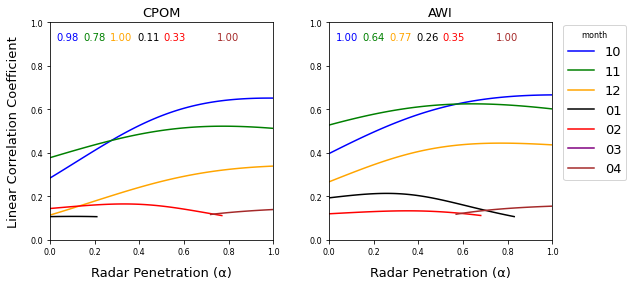

In [6]:
fig = plt.figure(figsize=(9,4))
plt.rc('font', size=8)
spec = gridspec.GridSpec(ncols=2, nrows=1, wspace=0.25, hspace=0.25)
colors = ['blue','green','orange','black','red','purple','brown']
xs = [0.08,0.2,0.32,0.44,0.56,0.68,0.8,0.92]

for c,name in enumerate(names):
    ax = plt.subplot(spec[c])

    for count,month in enumerate(months):
        ax.plot(alphas/100, all_rs[name][month],label = month,color=colors[count])
        try:
            ax.text(xs[count], 0.92, f'{np.nanargmax(all_rs[name][month])/100:.2f}', ha='center',fontsize = 10,
                    color=colors[count],transform = ax.transAxes)
        except:pass
    ax.set_xlim([0,1])
    ax.set_xlabel('Radar Penetration (\u03B1)',fontsize=13,labelpad=10)
    ax.set_ylim([0,1])
    if c == 0:
        ax.set_ylabel('Linear Correlation Coefficient',fontsize=13,labelpad=10)
    ax.set_title(name,fontsize=13)
    if c == 1:
        ax.legend(bbox_to_anchor = (1.02, 1.02),fontsize=13,title='month')
        
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/optimal_alpha_monthly.jpg',
            bbox_inches = "tight", dpi = 400)